<a href="https://colab.research.google.com/github/langfordzd/bursts-cc-pt/blob/main/burst_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm /content/*
!rm -rf burst-methods

rm: cannot remove '/content/sample_data': Is a directory


In [2]:
!git clone https://github.com/langfordzd/burst-methods.git

Cloning into 'burst-methods'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 34 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (34/34), done.


In [3]:
%cd burst-methods

/content/burst-methods


In [4]:
!curl -L -J -O 'https://osf.io/anbf8/download'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   469  100   469    0     0   2333      0 --:--:-- --:--:-- --:--:--  2333
100 2834M  100 2834M    0     0  36.5M      0  0:01:17  0:01:17 --:--:-- 38.1M
curl: Saved to filename 'results.zip'


In [5]:
!unzip results.zip

Archive:  results.zip
  inflating: ecog_com.json           
  inflating: ecog_com.pkl            
  inflating: ecog_objs.pkl           
  inflating: lfp_com.json            
  inflating: lfp_com.pkl             
  inflating: lfp_objs.pkl            
  inflating: mouse_com.json          
  inflating: mouse_com.pkl           
  inflating: mouse_objs.pkl          


In [6]:
import pandas as pd
import json
with open("mouse_com.json", "r") as fp:  
    mouse = pd.read_json(json.load(fp)) 
with open("lfp_com.json", "rb") as fp:   
    lfp = pd.read_json(json.load(fp))
    lfp['loc'] = lfp['loc']+lfp['chan'].astype(str)
    lfp['monkey'] = lfp['loc'].astype(str).str[0]
    marco = lfp[lfp['monkey']=='M']
    pablo = lfp[lfp['monkey']=='P']
with open("ecog_com.json", "rb") as fp:   
    ecog = pd.read_json(json.load(fp))     

In [7]:
import pickle
with open("ecog_objs.pkl", "rb") as fp:  
    ecog_trials, ecog_bs, ecog_ids, _, _, _ = pickle.load(fp)
with open("lfp_objs.pkl", "rb") as fp:  
    lfp_trials, lfp_bs, lfp_ids, _, _ = pickle.load(fp)

# New Section

In [8]:
%load plot1_stats.py
import plot1_stats as p1


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

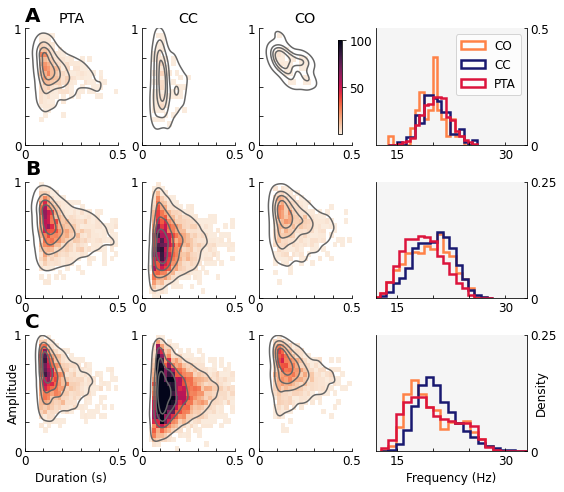

FileNotFoundError: ignored

In [9]:
p1.amp_dur(mouse,lfp,ecog)


In [10]:
p1.print_stats(mouse,'duration', 'mouse')
p1.print_stats(marco,'duration', 'marco')
p1.print_stats(pablo,'duration', 'pablo')
p1.print_stats(ecog,'duration', 'ecog')


--------------------------------------------
mouse
duration
[' PT:', '0.154', '0.00733', 'vs CC:', '0.115', '0.00942']
WilcoxonResult(statistic=0.0, pvalue=0.005062032126267864)
Ttest_relResult(statistic=-11.075990483318815, pvalue=1.5190886793362269e-06)
[0, 0.0]
--------------------------------------------
marco
duration
[' PT:', '0.169', '0.0143', 'vs CC:', '0.13', '0.00908']
WilcoxonResult(statistic=0.0, pvalue=0.0009815397525216685)
Ttest_relResult(statistic=-12.626318624462817, pvalue=1.1325587796588247e-08)
[0, 0.0]
--------------------------------------------
pablo
duration
[' PT:', '0.166', '0.0408', 'vs CC:', '0.144', '0.0111']
WilcoxonResult(statistic=17.0, pvalue=0.004853230851379527)
Ttest_relResult(statistic=-2.138097111655274, pvalue=0.0482849040276492)
[43, 0.0043]
--------------------------------------------
ecog
duration
[' PT:', '0.152', '0.00885', 'vs CC:', '0.159', '0.00556']
WilcoxonResult(statistic=51.0, pvalue=0.0026987267523070364)
Ttest_relResult(statistic=3.7

0